In [3]:
import numpy as np
import pandas as pd
from mlflow.tracking.client import MlflowClient
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from dotenv import load_dotenv

sns.set_style("ticks", {'axes.grid': True})
rcParams['figure.figsize'] = 12, 5
%matplotlib inline

pd.set_option('display.max_rows', 500)

In [4]:
load_dotenv()

client = MlflowClient()

def load_metric(run_id, metric_name, fill_missing=0) -> pd.Series:
    chart = client.get_metric_history(run_id, metric_name)
    steps = [metric.step for metric in chart]
    values = [metric.value for metric in chart]
    return (
        pd.Series(data=values, index=steps, name=metric_name)
        .reindex(range(max(steps) + 1), fill_value=fill_missing)
        .sort_index()
    )

def area(a):
    w = a[:, 2] - a[:, 0]
    h = a[:, 3] - a[:, 1]
    return w * h

def intersect(a, b):
    dx = np.minimum(a[:, 2], b[:, 2]) - np.maximum(a[:, 0], b[:, 0])
    dy = np.minimum(a[:, 3], b[:, 3]) - np.maximum(a[:, 1], b[:, 1])
    return dx * dy * (dx >= 0) * (dy >= 0)

def iou(a, b):
    i = intersect(a, b)
    return i / (area(a) + area(b) - i)

In [1]:
id1 = "edcb5f4addb846cf8ee903a476ab1c70"
id2 = "f48e806530664c84b1cd8ee0eae38bed"

<Axes: >

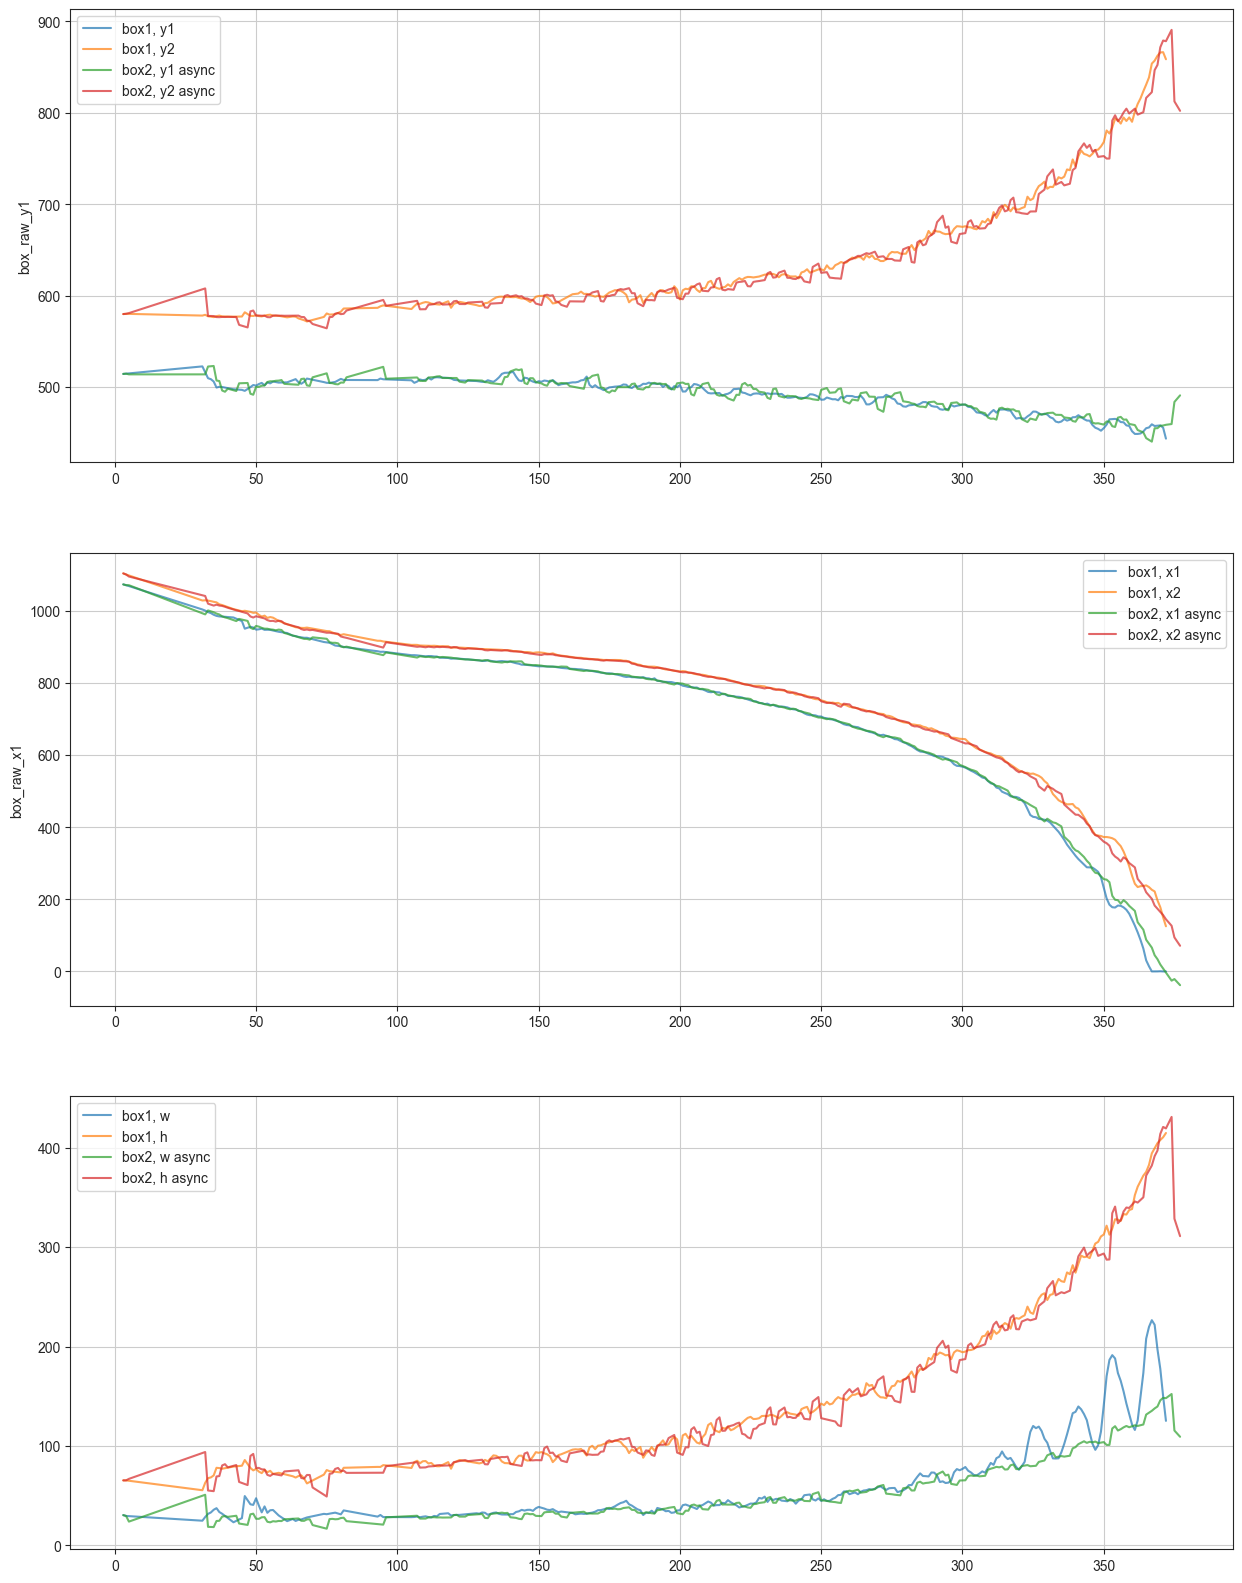

In [5]:
box1_y1 = load_metric(id1, "box_raw_y1", fill_missing=None)
box1_y2 = load_metric(id1, "box_raw_y2", fill_missing=None)
box2_y1 = load_metric(id2, "box_raw_y1", fill_missing=None)
box2_y2 = load_metric(id2, "box_raw_y2", fill_missing=None)
box1_x1 = load_metric(id1, "box_raw_x1", fill_missing=None)
box1_x2 = load_metric(id1, "box_raw_x2", fill_missing=None)
box2_x1 = load_metric(id2, "box_raw_x1", fill_missing=None)
box2_x2 = load_metric(id2, "box_raw_x2", fill_missing=None)

_, ax = plt.subplots(3, 1, figsize=(15, 20))

sns.lineplot(box1_y1, label="box1, y1", alpha=0.7, ax=ax[0])
sns.lineplot(box1_y2, label="box1, y2", alpha=0.7, ax=ax[0])
sns.lineplot(box2_y1, label="box2, y1 async", alpha=0.7, ax=ax[0])
sns.lineplot(box2_y2, label="box2, y2 async", alpha=0.7, ax=ax[0])

sns.lineplot(box1_x1, label="box1, x1", alpha=0.7, ax=ax[1])
sns.lineplot(box1_x2, label="box1, x2", alpha=0.7, ax=ax[1])
sns.lineplot(box2_x1, label="box2, x1 async", alpha=0.7, ax=ax[1])
sns.lineplot(box2_x2, label="box2, x2 async", alpha=0.7, ax=ax[1])

sns.lineplot(box1_x2 - box1_x1, label="box1, w", alpha=0.7, ax=ax[2])
sns.lineplot(box1_y2 - box1_y1, label="box1, h", alpha=0.7, ax=ax[2])
sns.lineplot(box2_x2 - box2_x1, label="box2, w async", alpha=0.7, ax=ax[2])
sns.lineplot(box2_y2 - box2_y1, label="box2, h async", alpha=0.7, ax=ax[2])

<Axes: ylabel='object_dist_avg'>

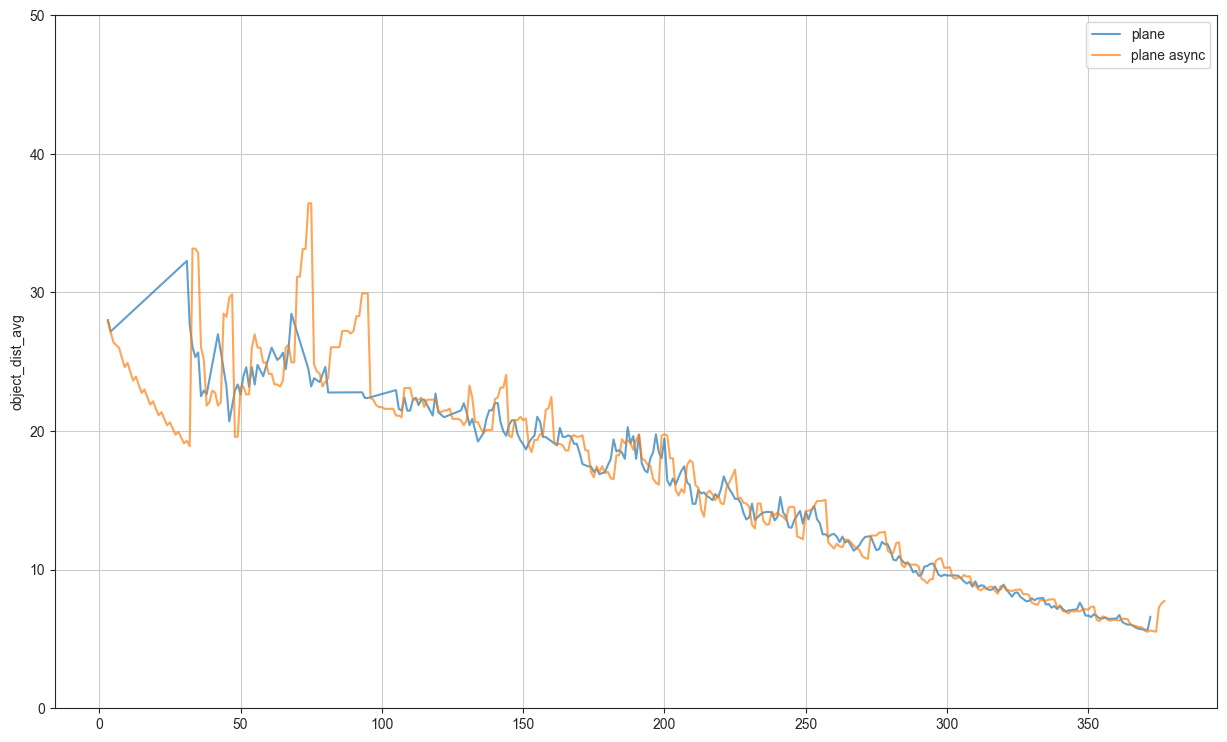

In [6]:
dist1 = load_metric(id1, "object_dist_avg", fill_missing=None)
dist2 = load_metric(id2, "object_dist_avg", fill_missing=None)

plt.figure(figsize=(15, 9))
plt.ylim(ymax=50)
sns.lineplot(dist1, label="plane", alpha=0.7)
sns.lineplot(dist2, label="plane async", alpha=0.7)

# 1. plane.mp4 (airplane)

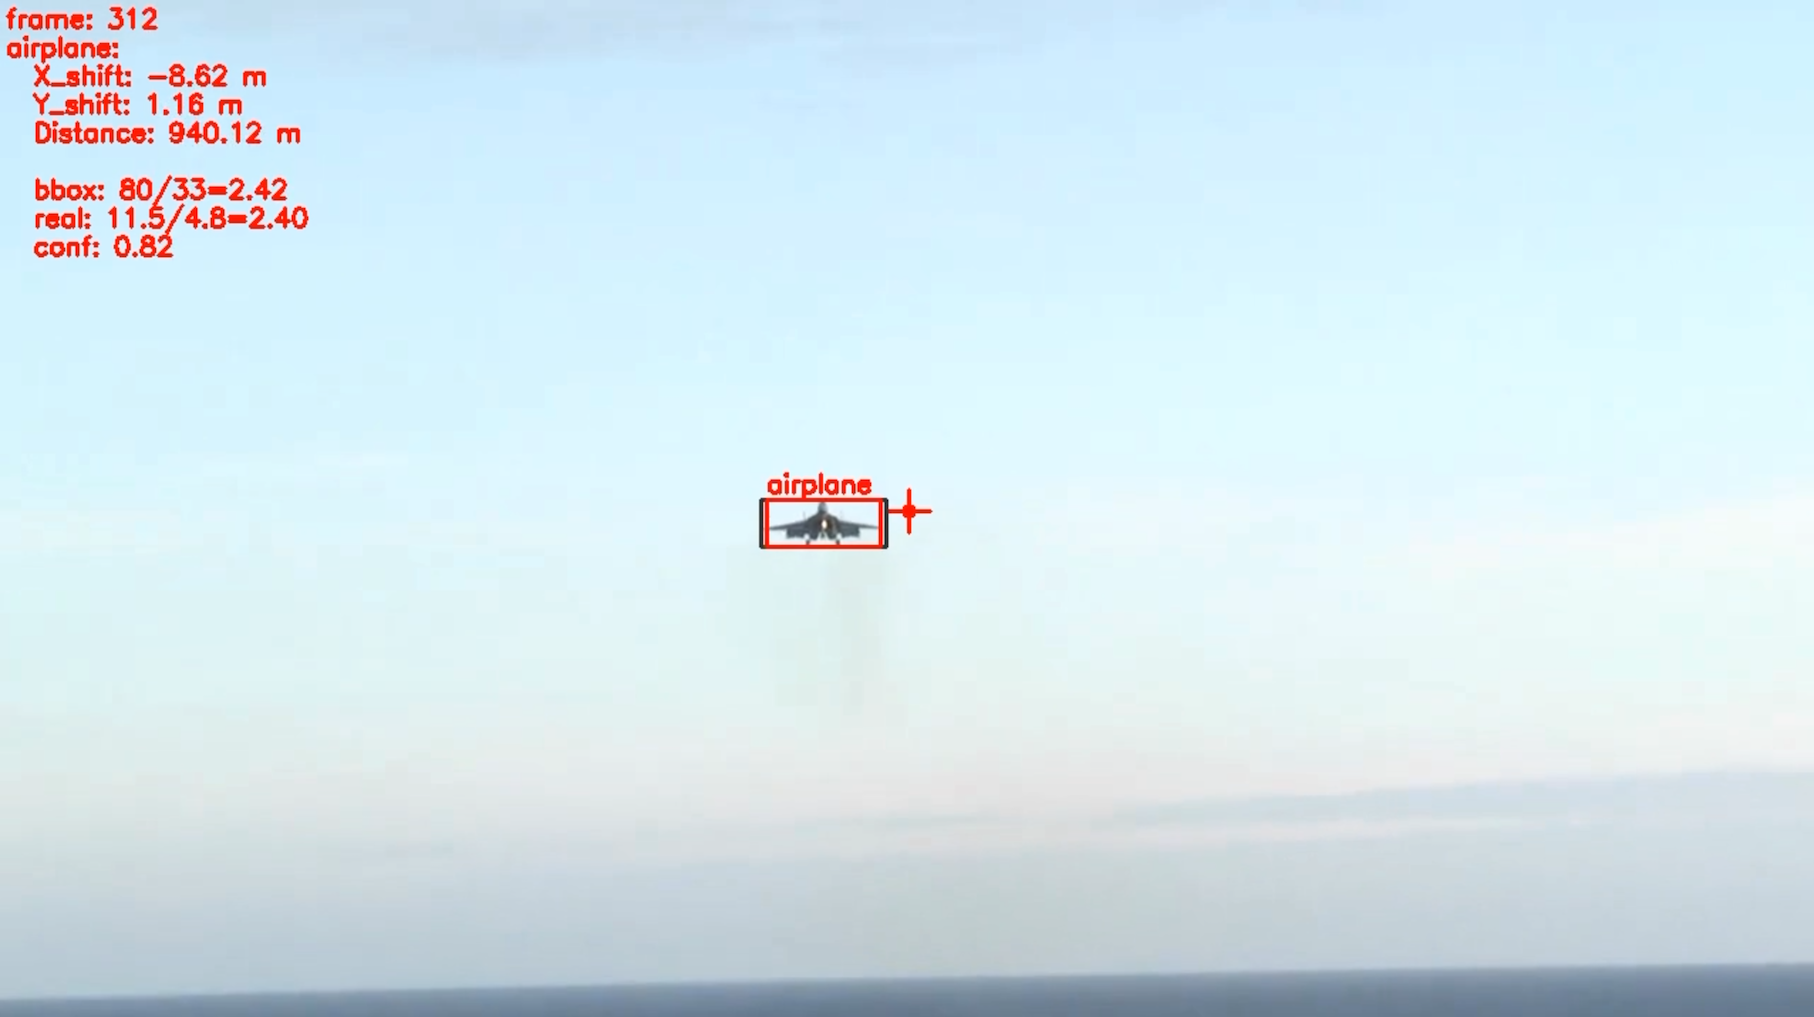

In [3]:
plane_id = "db2eebb3b1a247028f4fdbd5cdacade7"
plane_params = client.get_run(plane_id).data.params
plane_params

{'model': 'yolov8n.pt',
 'conf': '0.2',
 'sample': 'plane.mp4',
 'oname': 'airplane',
 'owidth': '11.5',
 'oheight': '4.8',
 'cfocal': '25.0',
 'cwidth': '4.92',
 'cheight': '2.77',
 'ratiodev': '0.4',
 'smooth': '1.0'}

### размеры пикселей камеры

In [4]:
px_size_x = load_metric(plane_id, "px_size_x", fill_missing=None)
px_size_y = load_metric(plane_id, "px_size_y", fill_missing=None)

print(px_size_x.apply(["min", "max", "mean"]), px_size_y.apply(["min", "max", "mean"]), sep="\n")

min     0.003844
max     0.003844
mean    0.003844
Name: px_size_x, dtype: float64
min     0.003847
max     0.003847
mean    0.003847
Name: px_size_y, dtype: float64


In [5]:
print(f'sensor ratio={float(plane_params["cwidth"]) / float(plane_params["cheight"])}')
print(f'frame ratio={1280 / 720}')

sensor ratio=1.7761732851985559
frame ratio=1.7777777777777777


Размеры пикселей отличаются в 6 знаке после запятой из-за особенностей формирования изображения: соотношения линейных размеров сенсора и размеров изображения не совпадают идеально

### смещение объекта от центра

<Axes: ylabel='center_shift_x'>

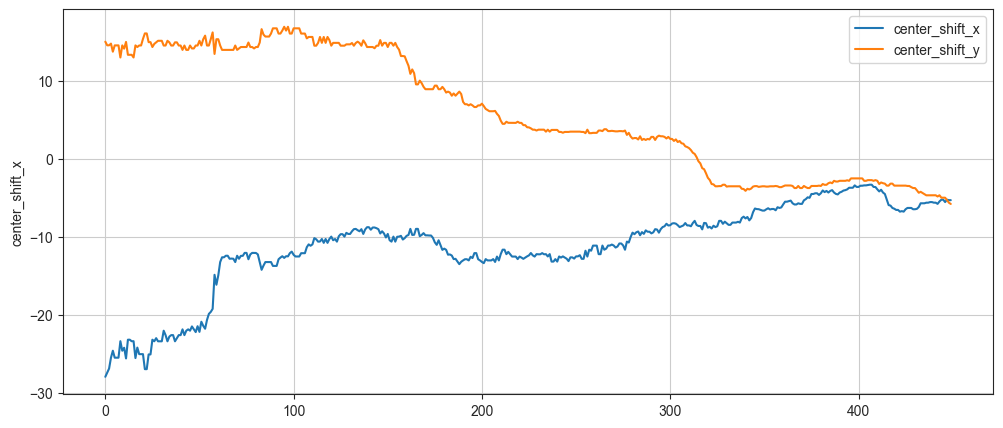

In [6]:
center_shift_x = load_metric(plane_id, "center_shift_x", fill_missing=None)
center_shift_y = load_metric(plane_id, "center_shift_y", fill_missing=None)

sns.lineplot(center_shift_x, label="center_shift_x")
sns.lineplot(center_shift_y, label="center_shift_y")

* `center_shift_x` - смещение объекта по горизонтальной оси
* `center_shift_y` - смещение объекта по вертикальной оси

По видео видно, что камера периодически смещается. Резкие изменения на графиках показывают эти моменты

### расстояние до объекта

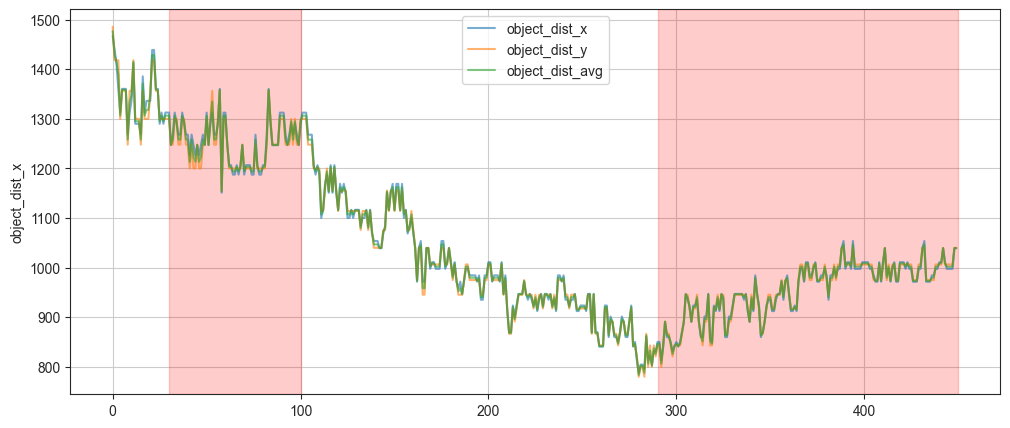

In [7]:
object_dist_x = load_metric(plane_id, "object_dist_x", fill_missing=None)
object_dist_y = load_metric(plane_id, "object_dist_y", fill_missing=None)
object_dist_avg = load_metric(plane_id, "object_dist_avg", fill_missing=None)

sns.lineplot(object_dist_x, alpha=0.6, label="object_dist_x")
sns.lineplot(object_dist_y, alpha=0.6, label="object_dist_y")
sns.lineplot(object_dist_avg, alpha=0.6, label="object_dist_avg")
plt.axvspan(30, 100, alpha=0.2, color='red')
plt.axvspan(290, 450, alpha=0.2, color='red')

* `object_dist_x` - расстояние от наблюдателя до проекции центра объекта на горизонтальную ось
* `object_dist_y` - расстояние от наблюдателя до проекции центра объекта на вертикальную ось
* `object_dist_avg` - расстояние от наблюдателя до центра объекта

1. На графике видно, что все 3 расстояния находятся очень близко друг к другу
2. Также на графике есть области (помечены красным), где поведение графика меняется:
  * левая область - расстояние до объекта перестает уменьшаться
  * правая область - расстояние до объекта начинает увеличиваться.
3. Для правой области на видео заметно, что камера не просто меняет положение, а меняется фокусное расстояние, так что нельзя достоверно указать расстояние до объекта на этой области

### коэффициент подобия для расчета реальных размеров объекта

<Axes: ylabel='sim_koef_x'>

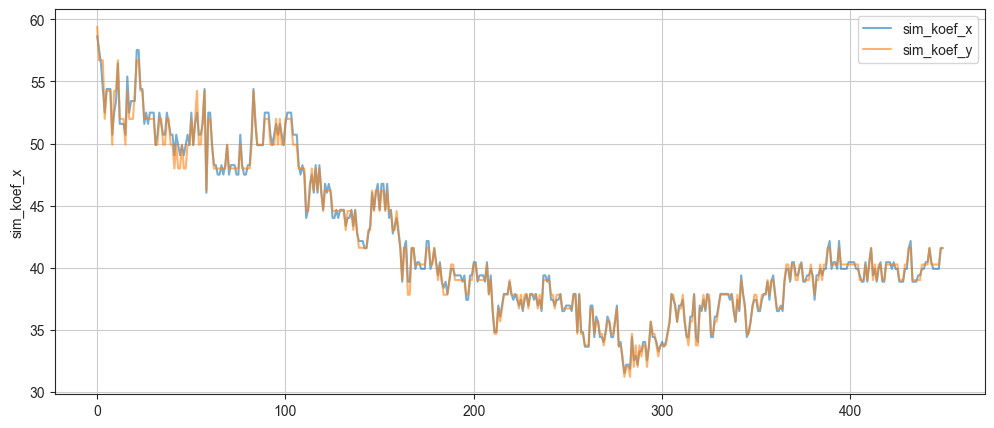

In [8]:
sim_koef_x = load_metric(plane_id, "sim_koef_x", fill_missing=None)
sim_koef_y = load_metric(plane_id, "sim_koef_y", fill_missing=None)

sns.lineplot(sim_koef_x, alpha=0.6, label="sim_koef_x")
sns.lineplot(sim_koef_y, alpha=0.6, label="sim_koef_y")

In [9]:
print(sim_koef_x.corr(object_dist_x))
print(sim_koef_y.corr(object_dist_y))

0.9999999534167179
0.9999999905794713


Для самопроверки: коэффициент подобия меняется пропорционально изменению расстояния до объекта

### размеры рамки детектора

<Axes: >

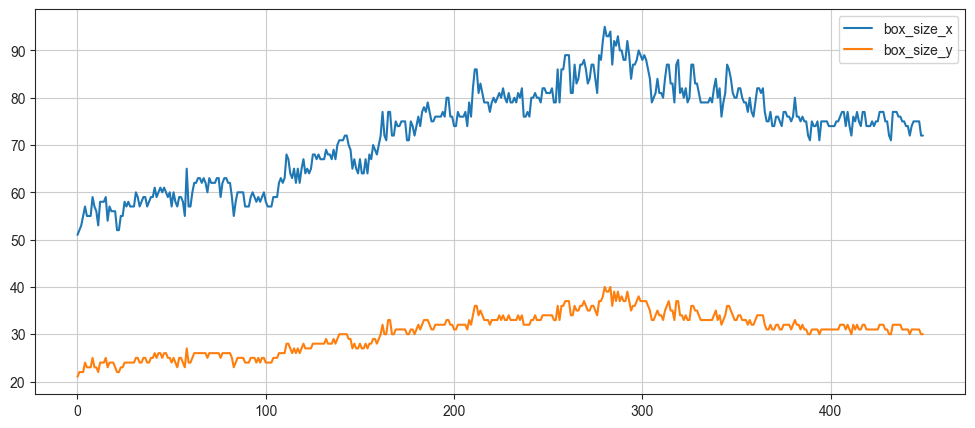

In [10]:
box_x1 = load_metric(plane_id, "box_x1", fill_missing=None)
box_x2 = load_metric(plane_id, "box_x2", fill_missing=None)
box_y1 = load_metric(plane_id, "box_y1", fill_missing=None)
box_y2 = load_metric(plane_id, "box_y2", fill_missing=None)

sns.lineplot(box_x2 - box_x1, label="box_size_x")
sns.lineplot(box_y2 - box_y1, label="box_size_y")

У объекта горизонтальные размеры больше чем вертикальные

### уверенность детектора в предсказании объекта

<Axes: ylabel='object_conf'>

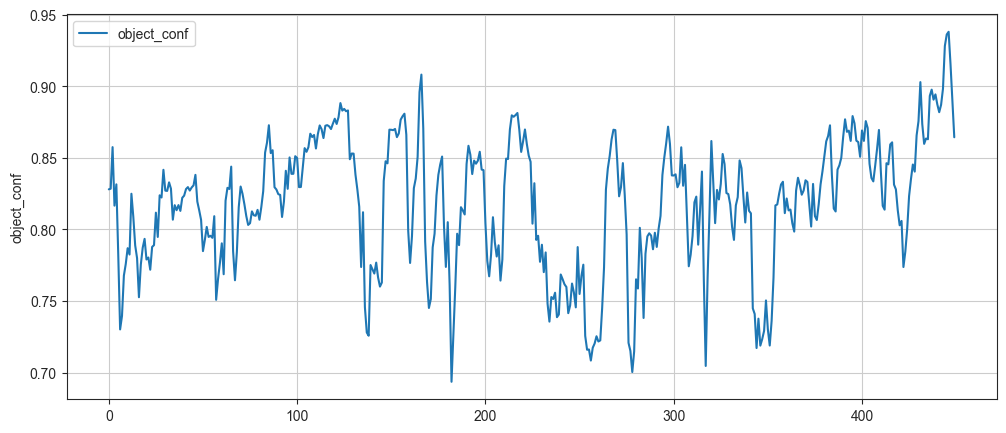

In [11]:
object_conf = load_metric(plane_id, "object_conf", fill_missing=0)

sns.lineplot(object_conf, label="object_conf")

Уверенность детектора остается на высоком уровне на протяжении всего видео

### сглаживание движения рамки детектора

In [12]:
plane_smooth_id = "993c0a1e8afe407791faad5a47cd2a41"
plane_smooth_params = client.get_run(plane_smooth_id).data.params
plane_smooth_params

{'model': 'yolov8n.pt',
 'conf': '0.2',
 'sample': 'plane.mp4',
 'oname': 'airplane',
 'owidth': '11.5',
 'oheight': '4.8',
 'cfocal': '25.0',
 'cwidth': '4.92',
 'cheight': '2.77',
 'ratiodev': '0.4',
 'smooth': '0.2'}

In [13]:
box1_x1 = load_metric(plane_id, "box_x1", fill_missing=None)
box2_raw_x1 = load_metric(plane_smooth_id, "box_raw_x1", fill_missing=None)

box1_x2 = load_metric(plane_id, "box_x2", fill_missing=None)
box2_raw_x2 = load_metric(plane_smooth_id, "box_raw_x2", fill_missing=None)

box1_y1 = load_metric(plane_id, "box_y1", fill_missing=None)
box2_raw_y1 = load_metric(plane_smooth_id, "box_raw_y1", fill_missing=None)

box1_y2 = load_metric(plane_id, "box_y2", fill_missing=None)
box2_raw_y2 = load_metric(plane_smooth_id, "box_raw_y2", fill_missing=None)

(np.abs(box1_x1 - box2_raw_x1).max(),
 np.abs(box1_x2 - box2_raw_x2).max(),
 np.abs(box1_y1 - box2_raw_y1).max(),
 np.abs(box1_y2 - box2_raw_y2).max()
)

(0.0, 0.0, 0.0, 0.0)

Параметры `box_raw_*` содержат координаты рамки до применения сглаживания. При сравнении соответствующих метрик двух экспериментов видно, что используемая модель дает одинаковые результаты 

<Axes: ylabel='object_dist_avg'>

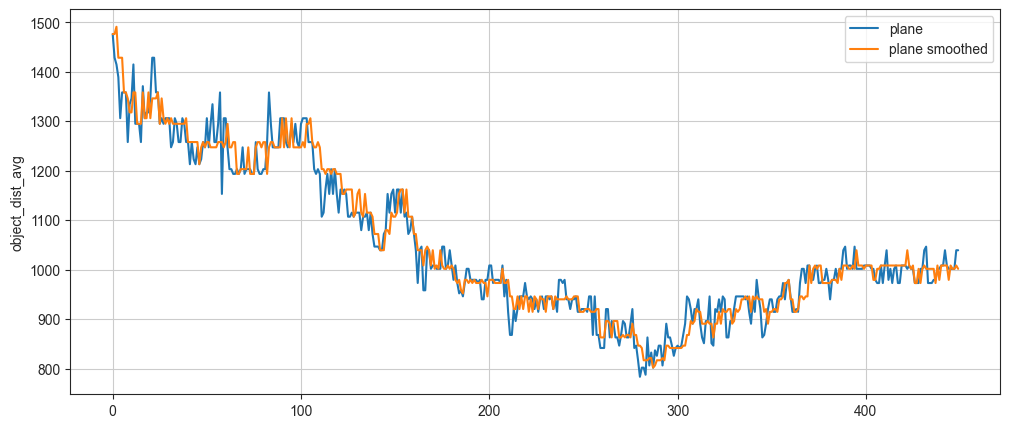

In [14]:
object_dist_avg1 = load_metric(plane_id, "object_dist_avg", fill_missing=None)
object_dist_avg2 = load_metric(plane_smooth_id, "object_dist_avg", fill_missing=None)

sns.lineplot(object_dist_avg1, label="plane")
sns.lineplot(object_dist_avg2, label="plane smoothed")

In [15]:
box2_x1 = load_metric(plane_smooth_id, "box_x1", fill_missing=None)
box2_x2 = load_metric(plane_smooth_id, "box_x2", fill_missing=None)
box2_y1 = load_metric(plane_smooth_id, "box_y1", fill_missing=None)
box2_y2 = load_metric(plane_smooth_id, "box_y2", fill_missing=None)

box2 = pd.concat([box2_x1, box2_y1, box2_x2, box2_y2], axis=1)
box1 = pd.concat([box1_x1, box1_y1, box1_x2, box1_y2], axis=1)

[Text(0.5, 1.0, 'IoU')]

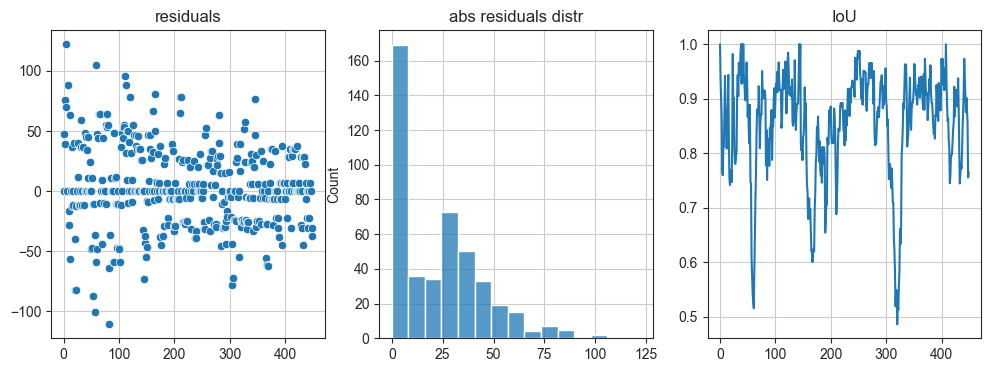

In [16]:
resid = (object_dist_avg2 - object_dist_avg1)

_, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(resid, ax=ax[0]).set(title="residuals", ylabel=None)
sns.histplot(np.abs(resid), ax=ax[1]).set(title="abs residuals distr", xlabel=None)
sns.lineplot(iou(box1.values, box2.values), ax=ax[2]).set(title="IoU")

# 2. fourway.avi (person)

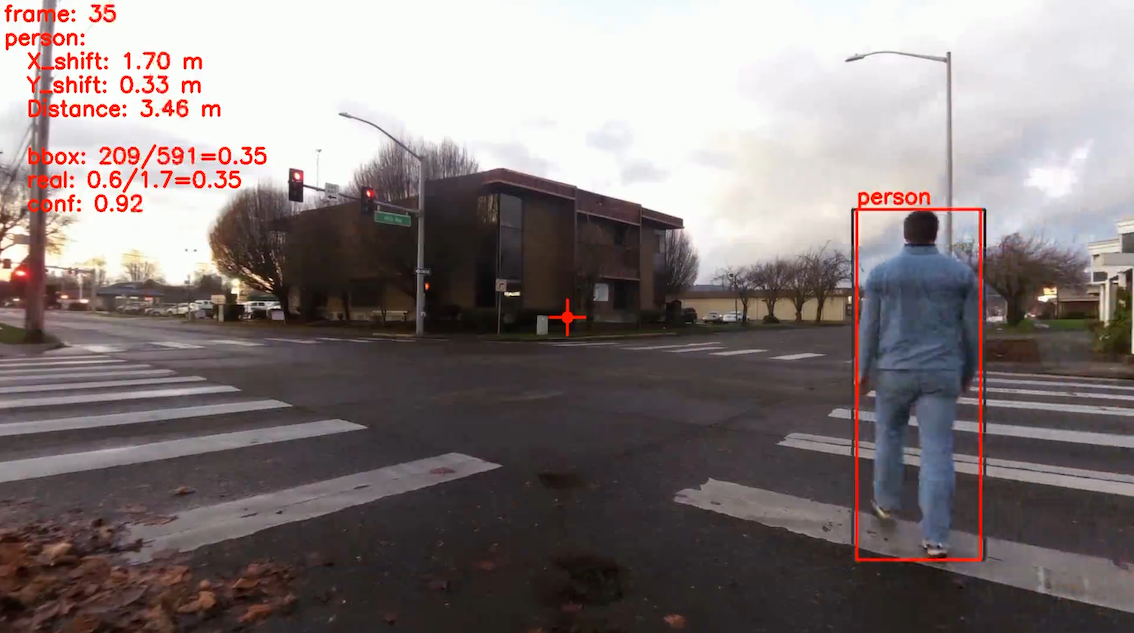

In [17]:
person_id = "c30e8b06b41949c6a805dcfd8a7bed0f"
person_params = client.get_run(person_id).data.params
person_params

{'model': 'yolov8n.pt',
 'conf': '0.2',
 'sample': 'fourway.avi',
 'oname': 'person',
 'owidth': '0.6',
 'oheight': '1.7',
 'cfocal': '4.0',
 'cwidth': '7.38',
 'cheight': '4.15',
 'ratiodev': '0.5',
 'smooth': '1.0'}

### размеры пикселей камеры

In [18]:
px_size_x = load_metric(person_id, "px_size_x", fill_missing=None)
px_size_y = load_metric(person_id, "px_size_y", fill_missing=None)

print(px_size_x.apply(["min", "max", "mean"]), px_size_y.apply(["min", "max", "mean"]), sep="\n")

min     0.003844
max     0.003844
mean    0.003844
Name: px_size_x, dtype: float64
min     0.003843
max     0.003843
mean    0.003843
Name: px_size_y, dtype: float64


In [19]:
print(f'sensor ratio={float(person_params["cwidth"]) / float(person_params["cheight"])}')
print(f'frame ratio={1920 / 1080}')

sensor ratio=1.778313253012048
frame ratio=1.7777777777777777


Размеры пикселей отличаются в 6 знаке после запятой из-за особенностей формирования изображения: соотношения линейных размеров сенсора и размеров изображения не совпадают идеально

### смещение объекта от центра

<Axes: ylabel='center_shift_x'>

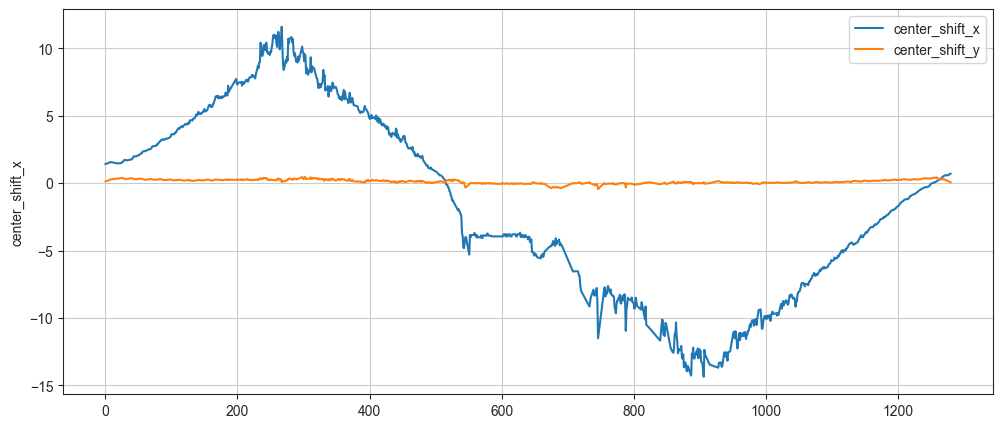

In [20]:
center_shift_x = load_metric(person_id, "center_shift_x", fill_missing=None)
center_shift_y = load_metric(person_id, "center_shift_y", fill_missing=None)

sns.lineplot(center_shift_x, label="center_shift_x")
sns.lineplot(center_shift_y, label="center_shift_y")

* `center_shift_x` - смещение объекта по горизонтальной оси
* `center_shift_y` - смещение объекта по вертикальной оси

Из-за расположения камеры объект смещается практически только по горизонтальной оси

### расстояние до объекта

<Axes: ylabel='object_dist_x'>

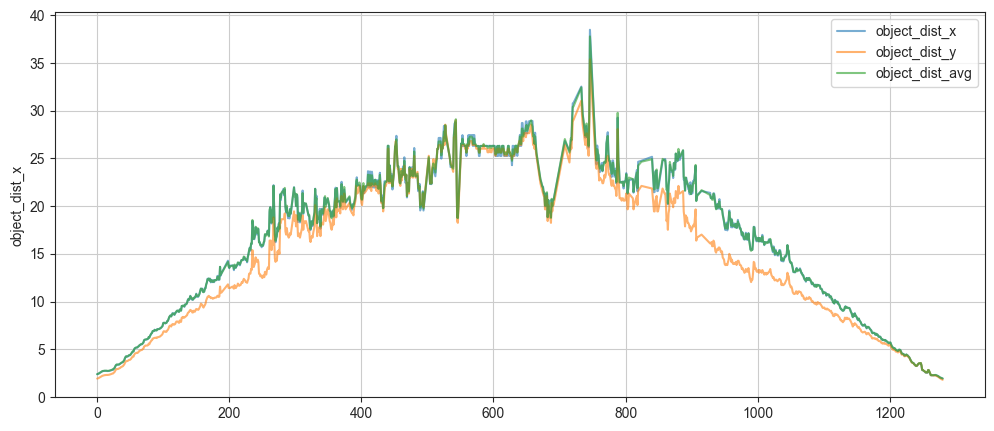

In [21]:
object_dist_x = load_metric(person_id, "object_dist_x", fill_missing=None)
object_dist_y = load_metric(person_id, "object_dist_y", fill_missing=None)
object_dist_avg = load_metric(person_id, "object_dist_avg", fill_missing=None)

sns.lineplot(object_dist_x, alpha=0.6, label="object_dist_x")
sns.lineplot(object_dist_y, alpha=0.6, label="object_dist_y")
sns.lineplot(object_dist_avg, alpha=0.6, label="object_dist_avg")

<Axes: ylabel='center_dist_y'>

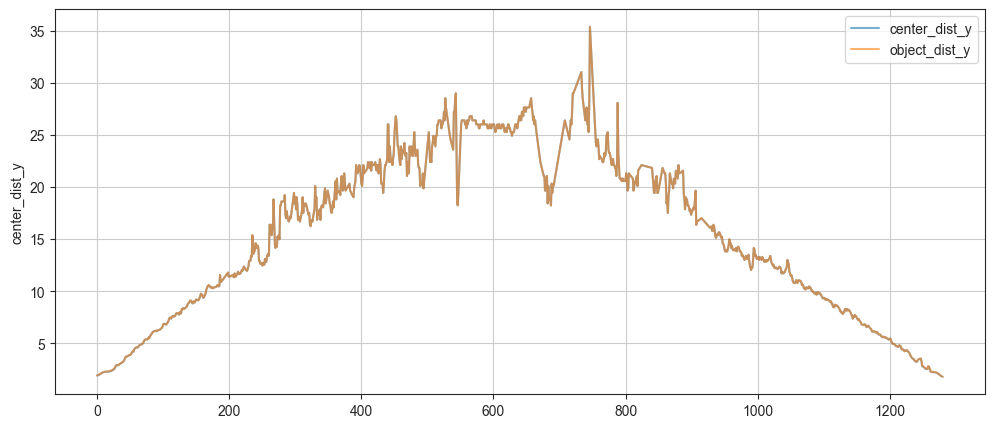

In [22]:
center_dist_y = load_metric(person_id, "center_dist_y", fill_missing=None)

sns.lineplot(center_dist_y, alpha=0.6, label="center_dist_y")
sns.lineplot(object_dist_y, alpha=0.6, label="object_dist_y")

* `object_dist_x` - расстояние от наблюдателя до проекции центра объекта на горизонтальную ось
* `object_dist_y` - расстояние от наблюдателя до проекции центра объекта на вертикальную ось
* `object_dist_avg` - расстояние от наблюдателя до центра объекта
* `center_dist_y` - расстояние от наблюдателя до центра кадра (по вертикальным размерам пикселей)

Видно, что проекция на вертикальную ось (`object_dist_y`) в некоторых местах сильно отклоняется от расстояния до объекта. Это происходит из-за того, что объект практически не смещается по вертикали, а только по горизонтали. И расстояние `object_dist_y` практически равно расстоянию `center_dist_y`

### коэффициент подобия для расчета реальных размеров объекта

<Axes: ylabel='sim_koef_x'>

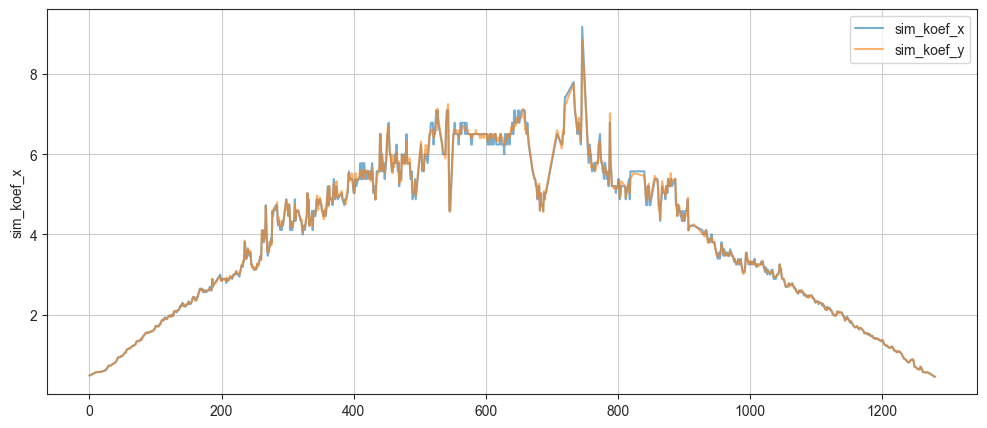

In [23]:
sim_koef_x = load_metric(person_id, "sim_koef_x", fill_missing=None)
sim_koef_y = load_metric(person_id, "sim_koef_y", fill_missing=None)

sns.lineplot(sim_koef_x, alpha=0.6, label="sim_koef_x")
sns.lineplot(sim_koef_y, alpha=0.6, label="sim_koef_y")

In [24]:
print(sim_koef_x.corr(object_dist_x))
print(sim_koef_y.corr(object_dist_y))

0.987148803946277
0.9999998388788872


Для самопроверки: коэффициент подобия меняется пропорционально изменению расстояния до объекта

### размеры рамки детектора

<Axes: >

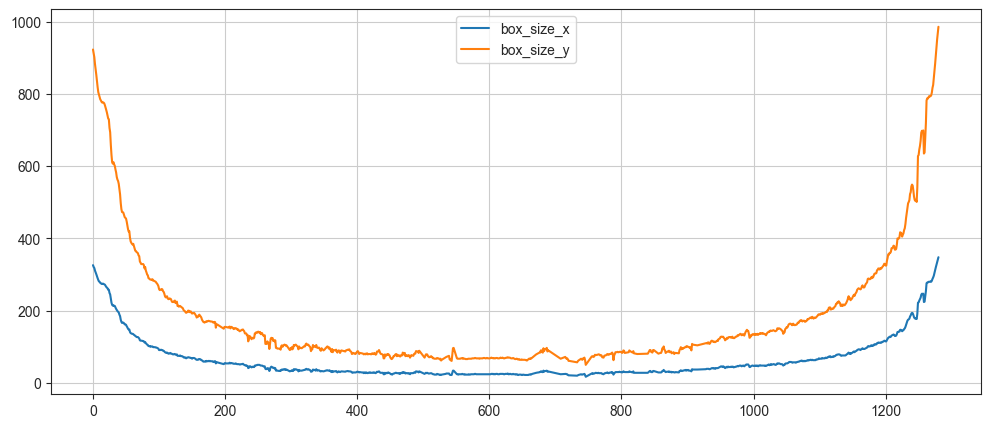

In [25]:
box_x1 = load_metric(person_id, "box_x1", fill_missing=None)
box_x2 = load_metric(person_id, "box_x2", fill_missing=None)
box_y1 = load_metric(person_id, "box_y1", fill_missing=None)
box_y2 = load_metric(person_id, "box_y2", fill_missing=None)

sns.lineplot(box_x2 - box_x1, label="box_size_x")
sns.lineplot(box_y2 - box_y1, label="box_size_y")

1. Объект имеет вертикальные размеры больше чем горизонтальные, так что метрика `box_size_x` имеет больший диапазон значений чем `box_size_x`
2. Из-за особенностей расположения камеры (на углу перекрестка) размеры объекта уменьшаются быстрее на первой зебре и увеличиваются быстрее на последней зебре

### уверенность детектора в предсказании объекта

<Axes: ylabel='object_conf'>

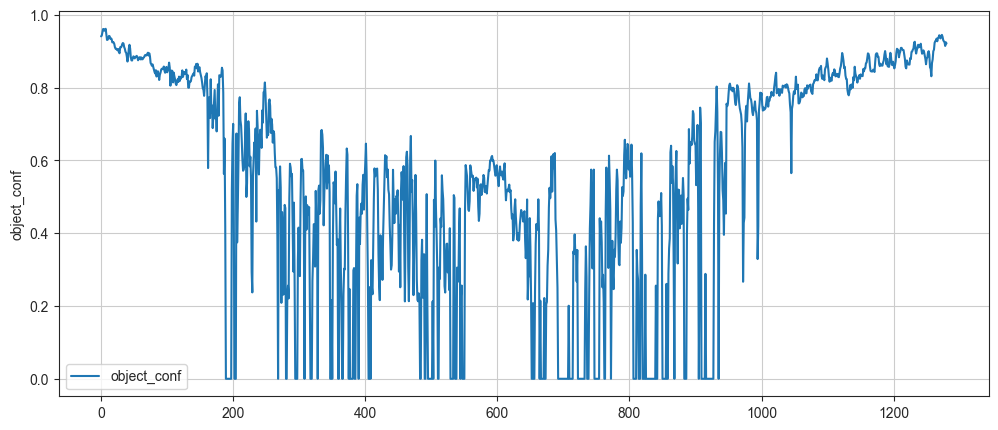

In [26]:
object_conf = load_metric(person_id, "object_conf", fill_missing=0)

sns.lineplot(object_conf, label="object_conf")

<Axes: ylabel='object_conf'>

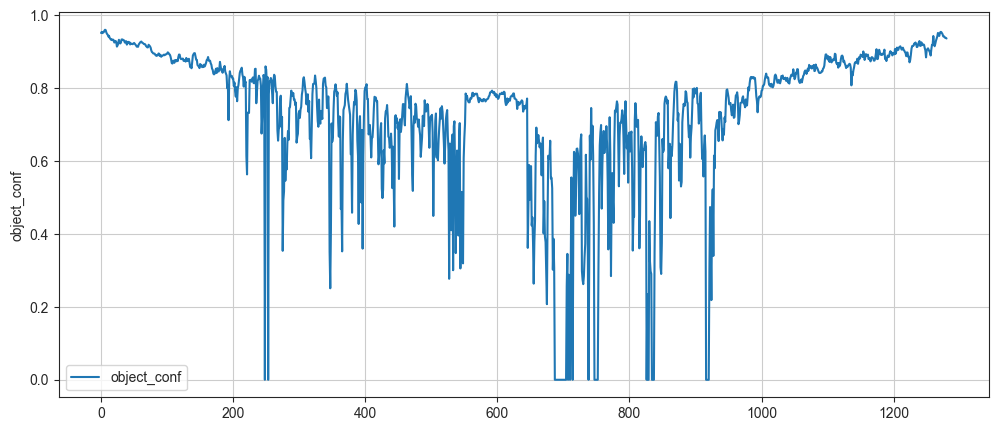

In [27]:
object_conf = load_metric("a1d7460b6510423096750462d80af65c", "object_conf", fill_missing=0)

sns.lineplot(object_conf, label="object_conf")

Видно, что детектору намного сложнее определять объект на большом расстоянии.

Также на первом графике работа детектора `yolov8n`, а на втором - более сложная модель `yolov8m`. Видно, что более сложная модель более уверена в своих предсказаниях

### сглаживание движения рамки детектора

In [28]:
person_smooth_id = "f7fd14035d9c435f8781d67751f7a4c7"
person_smooth_params = client.get_run(person_smooth_id).data.params
person_smooth_params

{'model': 'yolov8n.pt',
 'conf': '0.2',
 'sample': 'fourway.avi',
 'oname': 'person',
 'owidth': '0.6',
 'oheight': '1.7',
 'cfocal': '4.0',
 'cwidth': '7.38',
 'cheight': '4.15',
 'ratiodev': '0.5',
 'smooth': '0.2'}

In [29]:
box1_x1 = load_metric(person_id, "box_x1", fill_missing=None)
box2_raw_x1 = load_metric(person_smooth_id, "box_raw_x1", fill_missing=None)

box1_x2 = load_metric(person_id, "box_x2", fill_missing=None)
box2_raw_x2 = load_metric(person_smooth_id, "box_raw_x2", fill_missing=None)

box1_y1 = load_metric(person_id, "box_y1", fill_missing=None)
box2_raw_y1 = load_metric(person_smooth_id, "box_raw_y1", fill_missing=None)

box1_y2 = load_metric(person_id, "box_y2", fill_missing=None)
box2_raw_y2 = load_metric(person_smooth_id, "box_raw_y2", fill_missing=None)

(np.abs(box1_x1 - box2_raw_x1).max(),
 np.abs(box1_x2 - box2_raw_x2).max(),
 np.abs(box1_y1 - box2_raw_y1).max(),
 np.abs(box1_y2 - box2_raw_y2).max()
)

(9.0, 10.0, 1.0, 2.0)

Параметры `box_raw_*` содержат координаты рамки до применения сглаживания. При сравнении соответствующих метрик двух экспериментов видно, что используемая модель дает одинаковые результаты 

<Axes: ylabel='object_dist_avg'>

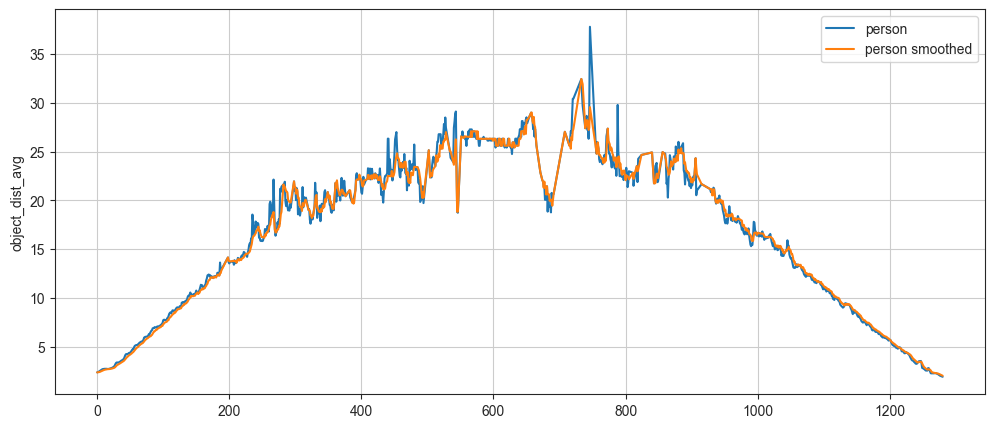

In [30]:
object_dist_avg1 = load_metric(person_id, "object_dist_avg", fill_missing=None)
object_dist_avg2 = load_metric(person_smooth_id, "object_dist_avg", fill_missing=None)

sns.lineplot(object_dist_avg1, label="person")
sns.lineplot(object_dist_avg2, label="person smoothed")

In [31]:
box2_x1 = load_metric(person_smooth_id, "box_x1", fill_missing=None)
box2_x2 = load_metric(person_smooth_id, "box_x2", fill_missing=None)
box2_y1 = load_metric(person_smooth_id, "box_y1", fill_missing=None)
box2_y2 = load_metric(person_smooth_id, "box_y2", fill_missing=None)

box2 = pd.concat([box2_x1, box2_y1, box2_x2, box2_y2], axis=1)
box1 = pd.concat([box1_x1, box1_y1, box1_x2, box1_y2], axis=1)

[Text(0.5, 1.0, 'IoU')]

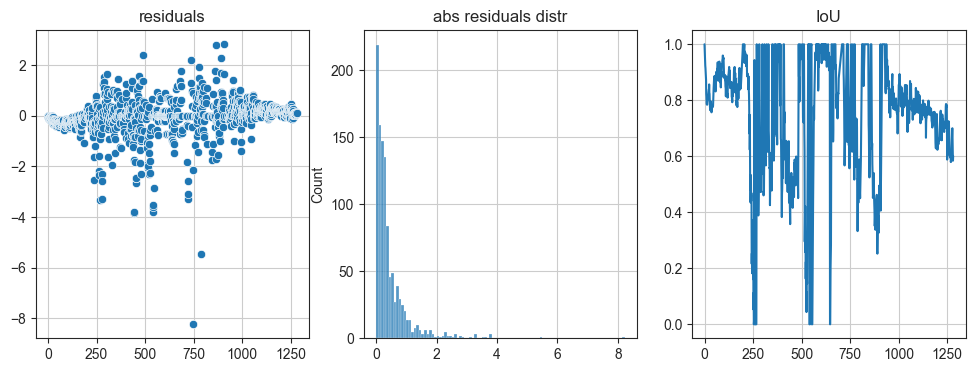

In [32]:
resid = (object_dist_avg2 - object_dist_avg1)

_, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(resid, ax=ax[0]).set(title="residuals", ylabel=None)
sns.histplot(np.abs(resid), ax=ax[1]).set(title="abs residuals distr", xlabel=None)
sns.lineplot(iou(box1.values, box2.values), ax=ax[2]).set(title="IoU")